# Error Analysis
Filter & manually inspect:
1. High MAE samples
2. High variance samples between the same trial settings (each nutrient)
3. High variance samples across different trial settings (each nutrient)

Quantitative Results
1. Does the model tend to overpredict / underpredict certain nutrients?
2. carb prediction gets worse for foreign countries. Is this the same with other nutrients?
3. carb prediction gets worse for higher carb / more meal items. Is this the same with other nutrients?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Investigate Base Prompting Strategy First

In [1]:
def filter_df(path, nutrient):
    df = pd.read_json(path, lines=True)

    doc_df = pd.json_normalize(df["doc"])
    result_df = pd.json_normalize(df["result"])

    result_df = result_df.rename(columns = {"mae" : nutrient + "_mae"})
    new = pd.concat([
        df[["doc_id", "pred", "resps"]].rename(columns={"pred" : nutrient + "_pred", "resps" : nutrient + "_resp"}),
        doc_df[["description", "country", "queries", "carb", "fat", "energy", "protein"]],
        result_df[[nutrient + "_mae"]]
    ], axis=1)

    new[nutrient + "_mae_norm"] = new[nutrient + "_mae"] / new[nutrient].mean()

    return new

In [4]:
carb_path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_base_20250722_043618.jsonl"
fat_path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_fat_base_20250719_184222.jsonl"
energy_path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_energy_base_20250721_222318.jsonl"
protein_path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_protein_base_20250719_191235.jsonl"

carb = filter_df(carb_path, "carb")
fat = filter_df(fat_path, "fat")
energy = filter_df(energy_path, "energy")
protein = filter_df(protein_path, "protein")
print(carb.head())

   doc_id  carb_pred                          carb_resp  \
0       0        0.0     [{{"total_carbohydrates": 0}}]   
1       1       61.8  [{{"total_carbohydrates": 61.8}}]   
2       2       24.0    [{{"total_carbohydrates": 24}}]   
3       3       37.5  [{{"total_carbohydrates": 37.5}}]   
4       4       41.6  [{{"total_carbohydrates": 41.6}}]   

                                         description country  \
0                    ['Water, bottled, unsweetened']     USA   
1  ['Water, bottled, unsweetened', 'Pizza with pe...     USA   
2       ['Ice cream bar, vanilla, chocolate coated']     USA   
3  ['Egg omelet or scrambled egg, with cheese, ma...     USA   
4  ['Apple, raw', 'Popcorn, ready-to-eat packaged...     USA   

                                             queries   carb    fat  energy  \
0  For a snack, I’m drinking 360 grams of bottled...   0.00   0.00    0.00   
1  For lunch, I'm having 240 grams of bottled uns...  63.41  14.82  502.04   
2  For a snack, I have a c

Visualize MAE distribution

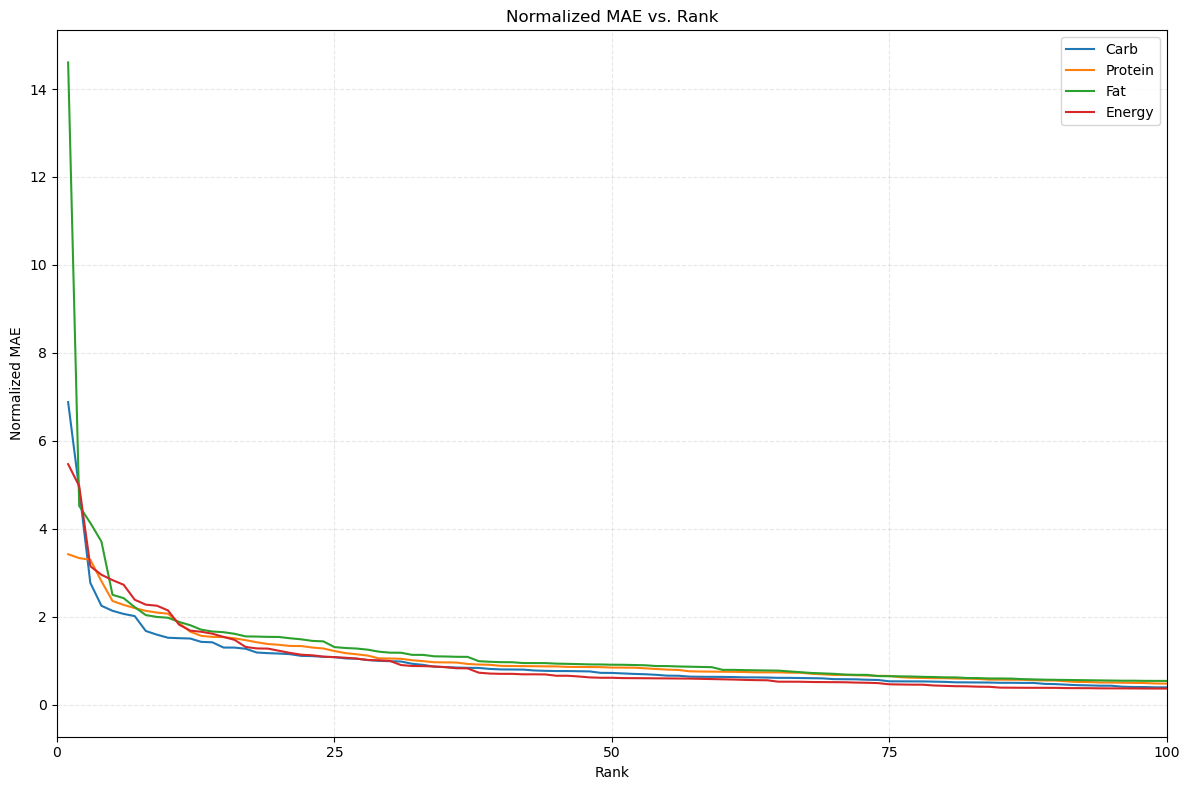

In [41]:
carb_sorted = carb.sort_values(by="carb_mae_norm", ascending=False)
carb_y = carb_sorted["carb_mae_norm"]
fat_y = fat.sort_values(by="fat_mae_norm", ascending=False)["fat_mae_norm"]
energy_y = energy.sort_values(by="energy_mae_norm", ascending=False)["energy_mae_norm"]
protein_y = protein.sort_values(by="protein_mae_norm", ascending=False)["protein_mae_norm"]

rank = np.arange(1, len(carb_sorted)+1)

plt.figure(figsize=(12, 8))
plt.plot(rank, carb_y, label="Carb")
plt.plot(rank, protein_y, label="Protein") 
plt.plot(rank, fat_y, label="Fat") 
plt.plot(rank, energy_y, label="Energy") 

plt.xticks(np.arange(0, len(carb_sorted) + 1, step=25))  
plt.xlabel("Rank")
plt.ylabel("Normalized MAE")
plt.title("Normalized MAE vs. Rank")
plt.grid(True, linestyle="--", alpha=0.3)
plt.xlim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

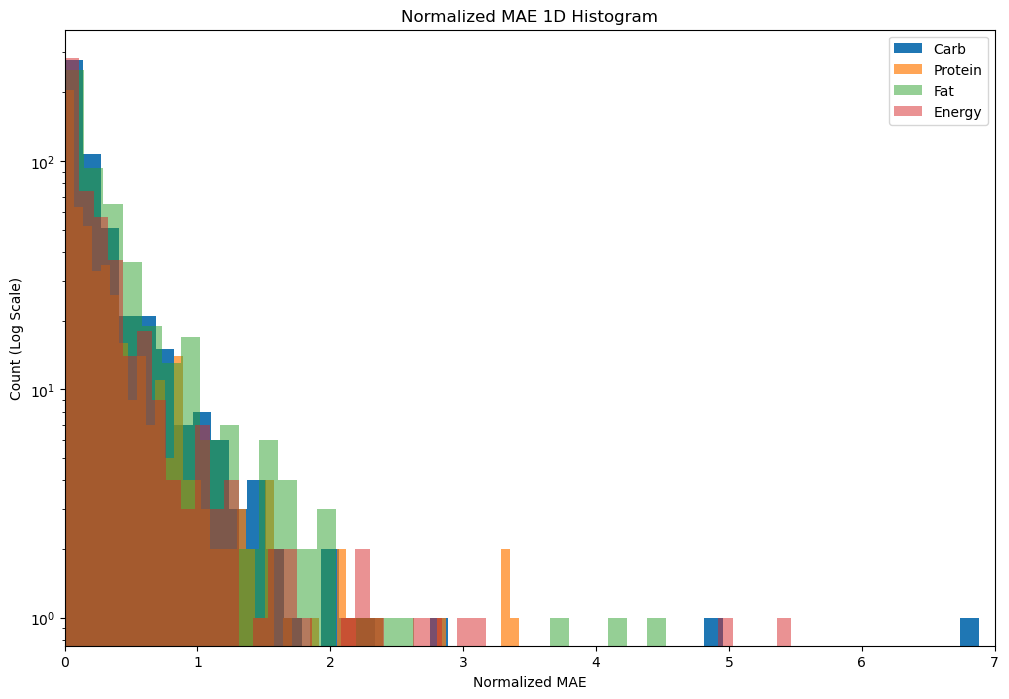

In [42]:
plt.figure(figsize=(12, 8))
plt.hist(carb_y, bins=50, alpha=1, label="Carb", log=True)
plt.hist(protein_y, bins=50, alpha=0.7, label="Protein", log=True)
plt.hist(fat_y, bins=100, alpha=0.5, label="Fat", log=True)
plt.hist(energy_y, bins=50, alpha=0.5, label="Energy", log=True)
plt.xlabel("Normalized MAE")
plt.ylabel("Count (Log Scale)")
plt.title("Normalized MAE 1D Histogram")
plt.xlim(0, 7)

plt.legend()
plt.show()

Manual Inspection of Top k=25 MAE Samples from Each Nutrient

In [53]:
drop_cols = ["description", "country", "queries", "carb", "fat", "energy", "protein"]

f = fat.drop(columns = drop_cols)
e = energy.drop(columns = drop_cols)
p = protein.drop(columns = drop_cols)

full_df = carb.merge(f, on="doc_id", how="inner")
full_df = full_df.merge(e, on="doc_id", how="inner")
full_df = full_df.merge(p, on="doc_id", how="inner")

print(full_df.head())

   doc_id  carb_pred                                        description  \
0       0        0.0                    ['Water, bottled, unsweetened']   
1       1       61.8  ['Water, bottled, unsweetened', 'Pizza with pe...   
2       2       24.0       ['Ice cream bar, vanilla, chocolate coated']   
3       3       37.5  ['Egg omelet or scrambled egg, with cheese, ma...   
4       4       41.6  ['Apple, raw', 'Popcorn, ready-to-eat packaged...   

  country                                            queries   carb    fat  \
0     USA  For a snack, I’m drinking 360 grams of bottled...   0.00   0.00   
1     USA  For lunch, I'm having 240 grams of bottled uns...  63.41  14.82   
2     USA  For a snack, I have a chocolate-coated vanilla...  18.38  18.08   
3     USA  I have a breakfast spread of a 135g egg and ch...  26.39  30.70   
4     USA  For my snack, I have a 200-gram apple and 28 g...  42.07   9.64   

   energy  protein  carb_mae  carb_mae_norm  fat_pred  fat_mae  fat_mae_norm  \


In [44]:
fat_sorted = fat.sort_values(by="fat_mae_norm", ascending=False)
energy_sorted = energy.sort_values(by="energy_mae_norm", ascending=False)
protein_sorted = protein.sort_values(by="protein_mae_norm", ascending=False)

carb_topk = carb_sorted["doc_id"].head(25)
fat_topk = fat_sorted["doc_id"].head(25)
energy_topk = energy_sorted["doc_id"].head(25)
protein_topk = protein_sorted["doc_id"].head(25)

topk_ids = pd.concat([carb_topk, fat_topk, energy_topk, protein_topk])
print(len(topk_ids))
topk_ids_unique = set(topk_ids)
print(len(topk_ids_unique))

topk_examples = full_df[full_df["doc_id"].isin(topk_ids_unique)]
topk_examples.to_csv("/data/lucasjia/projects/nutri/top_mae_examples.csv", index=False)

100
62


Overpredictions or Underpredictions?

In [45]:
carb_avg_error = topk_examples["carb_pred"].mean() - topk_examples["carb"].mean()
fat_avg_error = topk_examples["fat_pred"].mean() - topk_examples["fat"].mean()
energy_avg_error = topk_examples["energy_pred"].mean() - topk_examples["energy"].mean()
protein_avg_error = topk_examples["protein_pred"].mean() - topk_examples["protein"].mean()

print("top k:")
print(carb_avg_error)
print(fat_avg_error)
print(energy_avg_error)
print(protein_avg_error)

carb_full_error = full_df["carb_pred"].mean() - full_df["carb"].mean()
fat_full_error = full_df["fat_pred"].mean() - full_df["fat"].mean()
energy_full_error = full_df["energy_pred"].mean() - full_df["energy"].mean()
protein_full_error = full_df["protein_pred"].mean() - full_df["protein"].mean()

print("full df:")
print(carb_full_error)
print(fat_full_error)
print(energy_full_error)
print(protein_full_error)


top k:
16.488225806451595
-1.696612903225816
60.44532258064521
4.630645161290321
full df:
-0.0015283018867933151
-1.4076792452830187
0.2707358490565639
0.13286792452830198


In [46]:
def plot_error_hists(carb_df, fat_df, energy_df, protein_df):

    carb_errors = carb_df["carb_pred"].to_numpy() - carb_df["carb"].to_numpy()
    fat_errors = fat_df["fat_pred"].to_numpy() - fat_df["fat"].to_numpy()
    protein_errors = protein_df["protein_pred"].to_numpy() - protein_df["protein"].to_numpy()
    energy_errors = energy_df["energy_pred"].to_numpy() - energy_df["energy"].to_numpy()

    # Plot 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    axs[0, 0].hist(carb_errors, bins=100, log=True, color="blue", alpha=0.7)
    axs[0, 0].set_title("Carb Prediction Errors")

    axs[0, 1].hist(fat_errors, bins=100, log=True, color="green", alpha=0.7)
    axs[0, 1].set_title("Fat Prediction Errors")

    axs[1, 0].hist(energy_errors, bins=100, log=True, color="orange", alpha=0.7)
    axs[1, 0].set_title("Energy Prediction Errors")

    axs[1, 1].hist(protein_errors, bins=100, log=True, color="purple", alpha=0.7)
    axs[1, 1].set_title("Protein Prediction Errors")


    for ax in axs.flat:
        ax.set_xlabel("Error (Pred - GT)")
        ax.set_ylabel("Log Count")
        ax.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

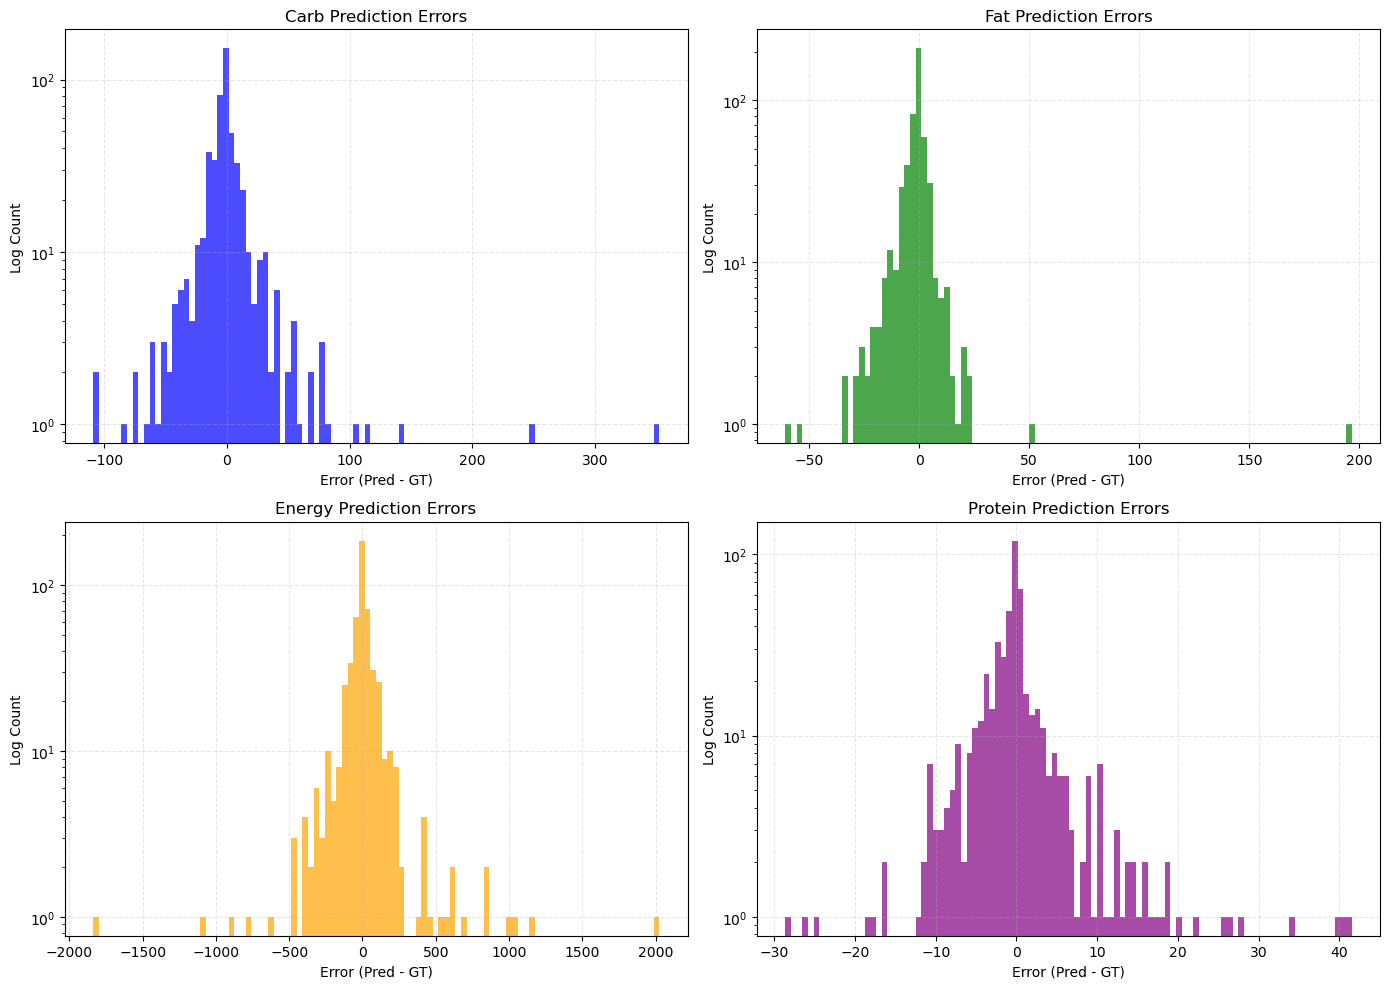

In [47]:
plot_error_hists(carb_sorted, fat_sorted, energy_sorted, protein_sorted)

Fat Underpredicted, Protein overpredicted

Next, error histograms for other strategies

In [54]:
carb_cot_path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_carb_CoT_20250719_051735.jsonl"
fat_cot_path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_fat_CoT_20250720_050526.jsonl"
energy_cot_path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_energy_CoT_20250720_053252.jsonl"
protein_cot_path = "/data/lucasjia/projects/nutri/results/multi-nutrient/sub1/samples_protein_CoT_20250720_060342.jsonl"

carb_cot = filter_df(carb_cot_path, "carb")
fat_cot = filter_df(fat_cot_path, "fat")
energy_cot = filter_df(energy_cot_path, "energy")
protein_cot = filter_df(protein_cot_path, "protein")

drop_cols = ["description", "country", "queries", "carb", "fat", "energy", "protein"]

f_cot = fat_cot.drop(columns = drop_cols)
e_cot = energy_cot.drop(columns = drop_cols)
p_cot = protein_cot.drop(columns = drop_cols)

full_cot_df = carb_cot.merge(f_cot, on="doc_id", how="inner")
full_cot_df = full_cot_df.merge(e_cot, on="doc_id", how="inner")
full_cot_df = full_cot_df.merge(p_cot, on="doc_id", how="inner")

print(full_cot_df.head())

   doc_id  carb_pred                                        description  \
0       0       0.00                    ['Water, bottled, unsweetened']   
1       1      58.00  ['Water, bottled, unsweetened', 'Pizza with pe...   
2       2      24.00       ['Ice cream bar, vanilla, chocolate coated']   
3       3      24.35  ['Egg omelet or scrambled egg, with cheese, ma...   
4       4      39.00  ['Apple, raw', 'Popcorn, ready-to-eat packaged...   

  country                                            queries   carb    fat  \
0     USA  For a snack, I’m drinking 360 grams of bottled...   0.00   0.00   
1     USA  For lunch, I'm having 240 grams of bottled uns...  63.41  14.82   
2     USA  For a snack, I have a chocolate-coated vanilla...  18.38  18.08   
3     USA  I have a breakfast spread of a 135g egg and ch...  26.39  30.70   
4     USA  For my snack, I have a 200-gram apple and 28 g...  42.07   9.64   

   energy  protein  carb_mae  carb_mae_norm  fat_pred  fat_mae  fat_mae_norm  \


In [55]:
carb_cot_error = full_cot_df["carb_pred"].mean() - full_cot_df["carb"].mean()
fat_cot_error = full_cot_df["fat_pred"].mean() - full_cot_df["fat"].mean()
energy_cot_error = full_cot_df["energy_pred"].mean() - full_cot_df["energy"].mean()
protein_cot_error = full_cot_df["protein_pred"].mean() - full_cot_df["protein"].mean()

print("full df:")
print(carb_cot_error)
print(fat_cot_error)
print(energy_cot_error)
print(protein_cot_error)


full df:
1.2684226603773538
-0.480826377358488
4.19441999999998
-0.02789832075471743


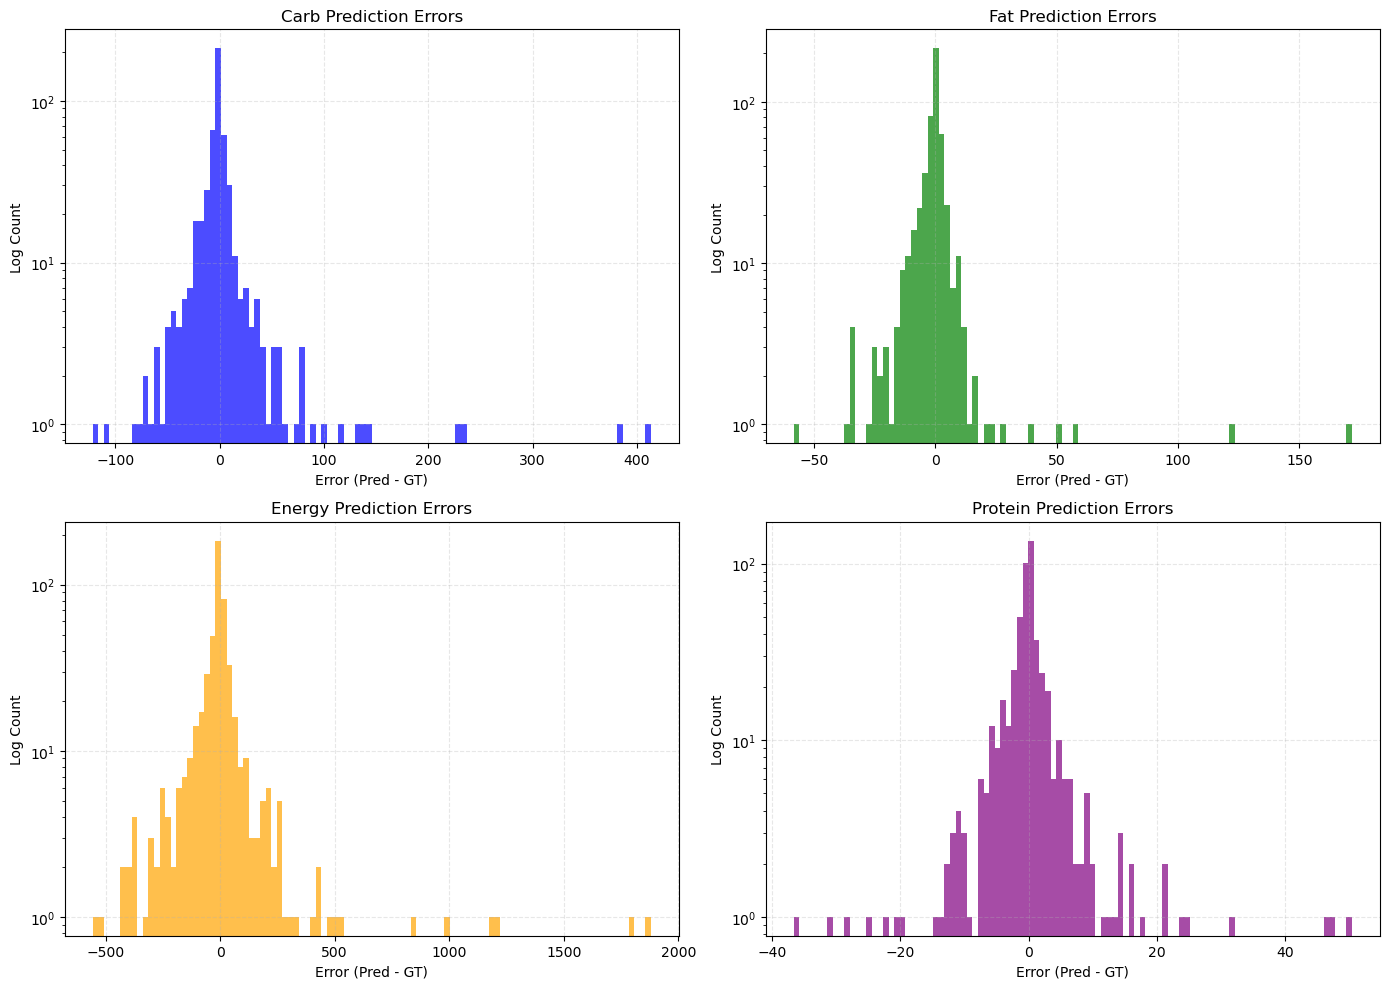

In [56]:
plot_error_hists(carb_cot, fat_cot, energy_cot, protein_cot)

In [57]:
carb_full_error = full_df["carb_pred"] - full_df["carb"]
fat_full_error = full_df["fat_pred"] - full_df["fat"]
energy_full_error = full_df["energy_pred"] - full_df["energy"]
protein_full_error = full_df["protein_pred"] - full_df["protein"]

print("base median:")
print(carb_full_error.median())
print(fat_full_error.median())
print(energy_full_error.median())
print(protein_full_error.median())


carb_cot_error = full_cot_df["carb_pred"] - full_cot_df["carb"]
fat_cot_error = full_cot_df["fat_pred"] - full_cot_df["fat"]
energy_cot_error = full_cot_df["energy_pred"] - full_cot_df["energy"]
protein_cot_error = full_cot_df["protein_pred"] - full_cot_df["protein"]

print("CoT median:")
print(carb_cot_error.median())
print(fat_cot_error.median())
print(energy_cot_error.median())
print(protein_cot_error.median())

base median:
-1.4449999999999998
-0.38999999999999985
-2.419999999999999
-0.18000000000000005
CoT median:
-0.7249999999999979
-0.0042300000000000115
-0.7900000000000009
-0.07000000000000028


Manual inspection of top k=25 MAE examples for each nutrient with CoT prompting

In [61]:
k=25
carb_cot_sorted = carb_cot.sort_values(by="carb_mae_norm", ascending=False)
fat_cot_sorted = fat_cot.sort_values(by="fat_mae_norm", ascending=False)
energy_cot_sorted = energy.sort_values(by="energy_mae_norm", ascending=False)
protein_cot_sorted = protein.sort_values(by="protein_mae_norm", ascending=False)

carb_cot_topk = carb_cot_sorted["doc_id"].head(k)
fat_cot_topk = fat_cot_sorted["doc_id"].head(k)
energy_cot_topk = energy_cot_sorted["doc_id"].head(k)
protein_cot_topk = protein_cot_sorted["doc_id"].head(k)

topk_cot_ids = pd.concat([carb_cot_topk, fat_cot_topk, energy_cot_topk, protein_cot_topk])
print(len(topk_cot_ids))
topk_cot_ids_unique = set(topk_cot_ids)
print(len(topk_cot_ids_unique))

topk_cot_examples = full_cot_df[full_cot_df["doc_id"].isin(topk_cot_ids_unique)]
topk_cot_examples.to_csv("/data/lucasjia/projects/nutri/top_mae_cot_examples.csv", index=False)

100
63


In [62]:
common_ids = topk_cot_ids_unique & topk_ids_unique
print(len(common_ids))

51
